Parameters of the largest circle:
Center: (110, 258)
Radius: 15
Sigma value: 2.0


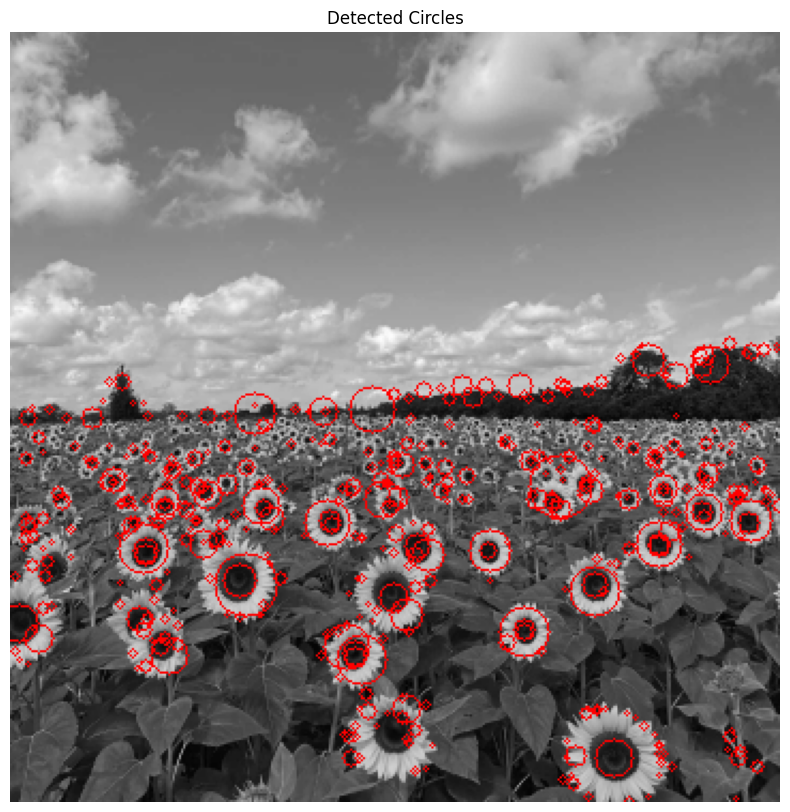

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the sunflower field image
image = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# Set up parameters for scale-space extrema detection
min_sigma = 1.0  # Minimum sigma value (smaller values for smaller blobs)
max_sigma = 2.0  # Maximum sigma value (larger values for larger blobs)
num_sigma = 2 # Number of sigma values to test
threshold = 0.35  # Threshold for blob detection

# Create an empty list to store detected circles
circles = []

# Loop through different sigma values to detect blobs at different scales
for sigma in np.linspace(min_sigma, max_sigma, num_sigma):
    # Apply LoG (Laplacian of Gaussian) to the grayscale image with the current sigma
    blurred = cv2.GaussianBlur(gray_image, (0, 0), sigma)
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)

    # Calculate the absolute Laplacian values
    abs_laplacian = np.abs(laplacian)

    # Create a binary image where blobs are detected using the threshold
    blob_mask = abs_laplacian > threshold * abs_laplacian.max()

    # Find contours in the blob mask
    contours, _ = cv2.findContours(blob_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through the detected contours and fit circles to them
    for contour in contours:
        if len(contour) >= 5:
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            circles.append((center, radius, sigma))

# Sort the detected circles by radius in descending order
circles.sort(key=lambda x: -x[1])

# Report the parameters of the largest circle
largest_circle = circles[0]
center, radius, sigma = largest_circle

print("Parameters of the largest circle:")
print(f"Center: {center}")
print(f"Radius: {radius}")
print(f"Sigma value: {sigma}")

# Set the desired line thickness for drawn circles
line_thickness = 1

# Draw all detected circles with the specified line thickness
output_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
for circle in circles:
    center, radius, _ = circle
    cv2.circle(output_image, center, radius, (0, 0, 255), line_thickness)  # Red color

# Display the grayscale image with detected circles using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Detected Circles')
plt.show()



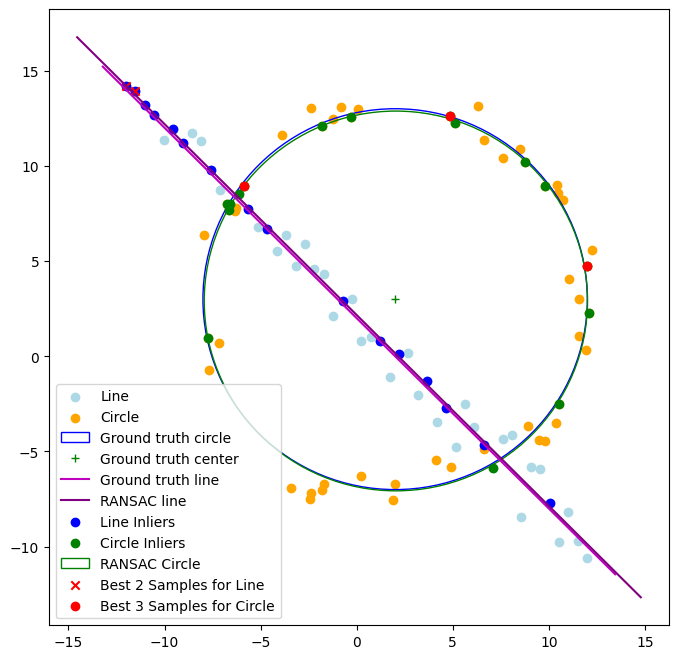

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(1)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

# Generate points for the circle
theta = np.random.uniform(0, 2 * np.pi, half_n)
noise = s * np.random.randn(half_n)
x_circle = x0_gt + (r + noise) * np.cos(theta)
y_circle = y0_gt + (r + noise) * np.sin(theta)

X_circ = np.column_stack((x_circle, y_circle))

# Generate points for the line
s = 1.0
m, b = -1, 2

x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s * np.random.randn(half_n)

X_line = np.column_stack((x_line, y_line))

# Concatenate points from both circle and line to create X
X = np.vstack((X_circ, X_line))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], color = 'lightblue', label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color = 'orange', label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='blue', fill=False, label='Ground truth circle')
ax.add_artist(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = m * x_range + b
plt.plot(x_range, y_range, color='m', label='Ground truth line')



# Define a function to calculate the line equation from two points
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line with unit normal constraint
def ransac_line(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 2, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        
        a, b, d = line_equation_from_points(x1, y1, x2, y2)
        
        # Constraint: Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        # Calculate the distance of all points to the line
        distances = np.abs(a*X[:,0] + b*X[:,1] - d)
        
        # Find inliers based on the threshold
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (a, b, d)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters
iterations = 10000
threshold = 0.15
min_inliers = 15

# Estimate the line using RANSAC
best_line_model, Line_inlier_indices = ransac_line(X_line, iterations, threshold, min_inliers)

# Define a function to calculate the circle equation from three points
def circle_equation_from_points(x1, y1, x2, y2, x3, y3):
    # Calculate the midpoints of two line segments
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x2 + x3) / 2, (y2 + y3) / 2
    
    # Calculate the slopes of the two lines
    if y2 - y1 == 0:
        slope1 = 0  # Avoid division by zero
    else:
        slope1 = (x2 - x1) / (y2 - y1)
    
    if y3 - y2 == 0:
        slope2 = 0  # Avoid division by zero
    else:
        slope2 = (x3 - x2) / (y3 - y2)
    
    # Calculate the center of the circle
    x_center = (slope1 * mx1 - slope2 * mx2 + my2 - my1) / (slope1 - slope2)
    y_center = -slope1 * (x_center - mx1) + my1
    
    # Calculate the radius
    radius = np.sqrt((x1 - x_center)**2 + (y1 - y_center)**2)
    
    return x_center, y_center, radius

# RANSAC to fit a circle
def ransac_circle(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 3, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        x3, y3 = X[sample_indices[2]]
        
        x_center, y_center, radius = circle_equation_from_points(x1, y1, x2, y2, x3, y3)
        
        # Calculate the radial error of all points to the circle
        errors = np.abs(np.sqrt((X[:, 0] - x_center)**2 + (X[:, 1] - y_center)**2) - radius)
        
        # Find inliers based on the threshold
        inliers = np.where(errors < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (x_center, y_center, radius)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters for circle estimation
circle_iterations = 10000
circle_threshold = 0.2  # Adjust the threshold as needed
circle_min_inliers = 15

# Identify the remnant points (not explained by the line)
remnant_indices = [i for i in range(len(X)) if i not in Line_inlier_indices]
remnant_points = X[remnant_indices]

# Estimate the circle using RANSAC
best_circle_model, circle_inlier_indices = ransac_circle(remnant_points, circle_iterations, circle_threshold, circle_min_inliers)


# Plot the results

# Plot the estimated line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[0] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC line', color='purple')


ax.scatter(X_line[Line_inlier_indices, 0], X_line[Line_inlier_indices, 1], color='blue', label='Line Inliers')


# Find the best 2 samples for the line
best_line_sample_indices = Line_inlier_indices[:2]
best_line_samples = X_line[best_line_sample_indices]


# Plot the inliers of the circle
ax.scatter(remnant_points[circle_inlier_indices, 0], remnant_points[circle_inlier_indices, 1], color='g', label='Circle Inliers')

# Plot the estimated circle
x_center, y_center, radius = best_circle_model
circle_estimated = plt.Circle((x_center, y_center), radius, color='g', fill=False, label='RANSAC Circle')
ax.add_artist(circle_estimated)

# Find the best 3 samples for the circle (using circle_inlier_indices)
best_circle_sample_indices = circle_inlier_indices[:3]
best_circle_samples = remnant_points[best_circle_sample_indices]


# Plot the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='o', label='Best 3 Samples for Circle')


plt.legend()
plt.show()



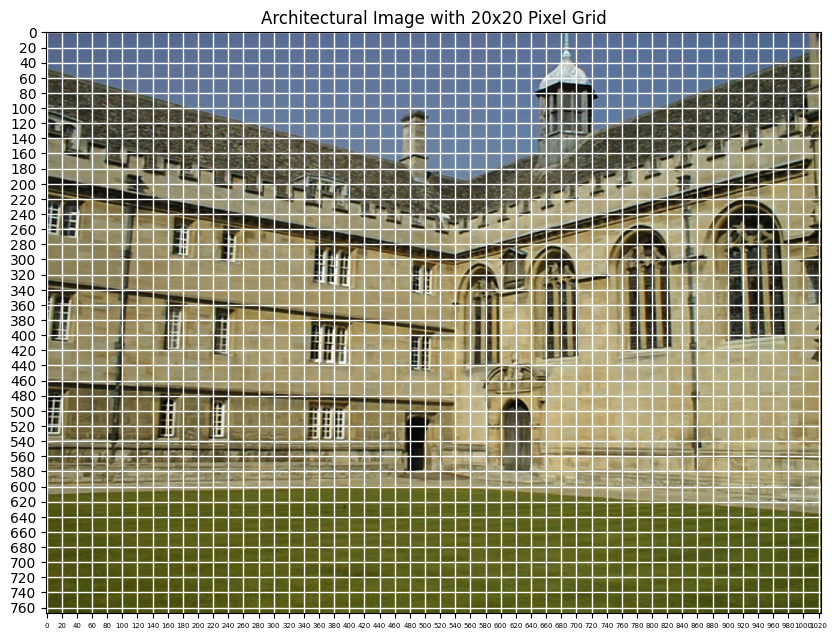

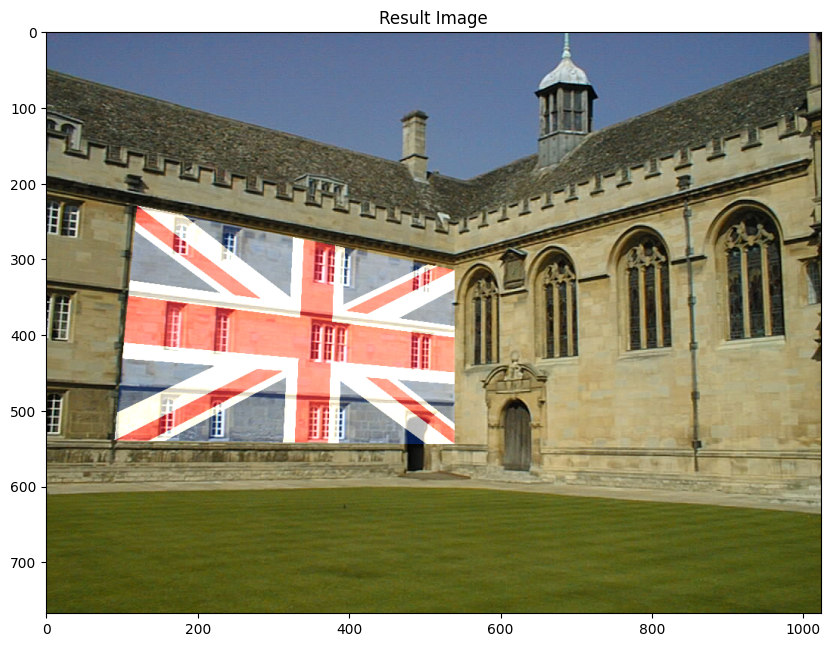

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the architectural image and the flag image
architectural_image = cv2.imread('architectural_image.jpg')
flag_image = cv2.imread('flag_image.png')

# Display the architectural image with a 20x20 pixel grid
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(architectural_image, cv2.COLOR_BGR2RGB))
plt.xticks(np.arange(0, architectural_image.shape[1], 20), fontsize=5)
plt.yticks(np.arange(0, architectural_image.shape[0], 20))
plt.grid(True, color='white', linewidth=1)
plt.title('Architectural Image with 20x20 Pixel Grid')
plt.show()

# Define the four points on the architectural image that form a planar surface
# Replace these with the actual coordinates
points_on_architecture = np.array([[120, 230], [540, 315], [540, 545], [90, 540]], dtype=np.float32)

# Define the corresponding points on the flag image (in the same order)
points_on_flag = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv2.findHomography(points_on_flag, points_on_architecture)

# Warp the flag image onto the architectural image using the homography
flag_warped = cv2.warpPerspective(flag_image, homography_matrix, (architectural_image.shape[1], architectural_image.shape[0]))

# Blend the warped flag image with the architectural image
result_image = cv2.addWeighted(architectural_image, 1, flag_warped, 0.7, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Result Image')
plt.show()



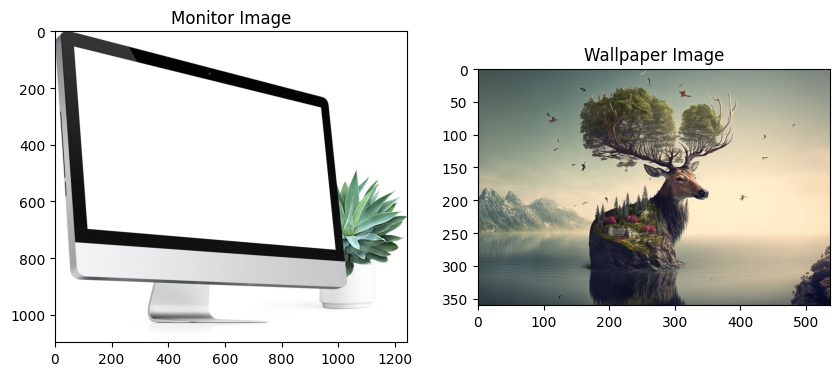

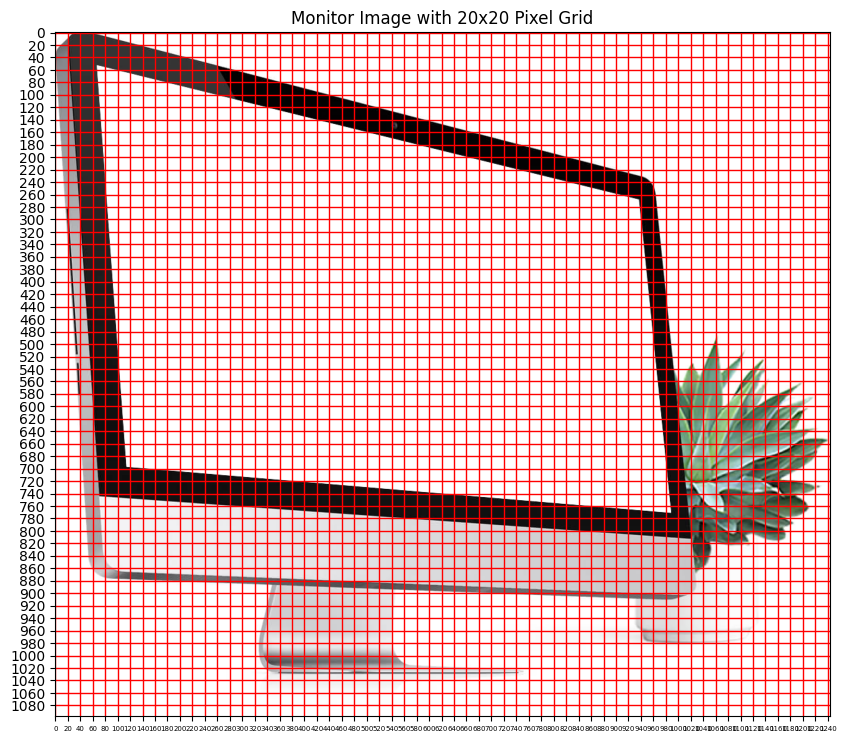

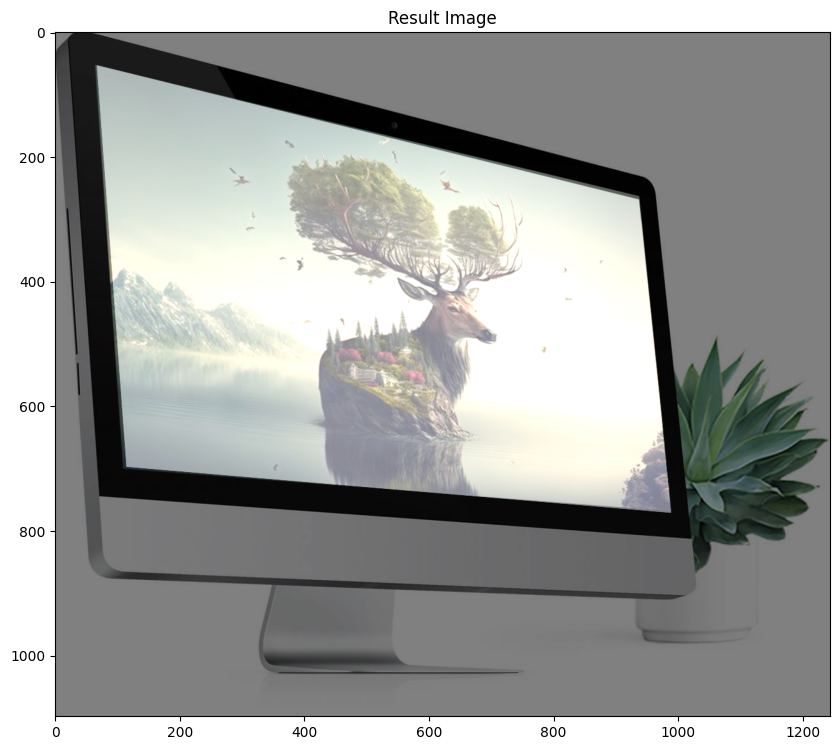

In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the monitor image and the wallpaper image
monitor_image = cv2.imread('monitor.png')
wallpaper_image = cv2.imread('new_image.jpg')

# Display two images side-by-side
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(monitor_image, cv2.COLOR_BGR2RGB))
plt.title('Monitor Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(wallpaper_image, cv2.COLOR_BGR2RGB))
plt.title('Wallpaper Image')
plt.show()

# Display the monitor image with a 20x20 pixel grid
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(monitor_image, cv2.COLOR_BGR2RGB))
plt.xticks(np.arange(0, monitor_image.shape[1], 20), fontsize=5)
plt.yticks(np.arange(0, monitor_image.shape[0], 20))
plt.grid(True, color='red', linewidth=1)
plt.title('Monitor Image with 20x20 Pixel Grid')
plt.show()

# Define the four points on the monitor image that form a planar surface
# Replace these with the actual coordinates
points_on_monitor = np.array([[65, 55], [938, 265], [990, 770], [110, 702]], dtype=np.float32)

# Define the corresponding points on the wallpaper image (in the same order)
points_on_wallpaper = np.array([[0, 0], [wallpaper_image.shape[1], 0], [wallpaper_image.shape[1], wallpaper_image.shape[0]], [0, wallpaper_image.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv2.findHomography(points_on_wallpaper, points_on_monitor)

# Warp the wallpaper image onto the monitor image using the homography
wallpaper_warped = cv2.warpPerspective(wallpaper_image, homography_matrix, (monitor_image.shape[1], monitor_image.shape[0]))

# Blend the warped wallpaper image with the monitor image
result_image = cv2.addWeighted(monitor_image, 0.5, wallpaper_warped, 0.7, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Result Image')
plt.show()


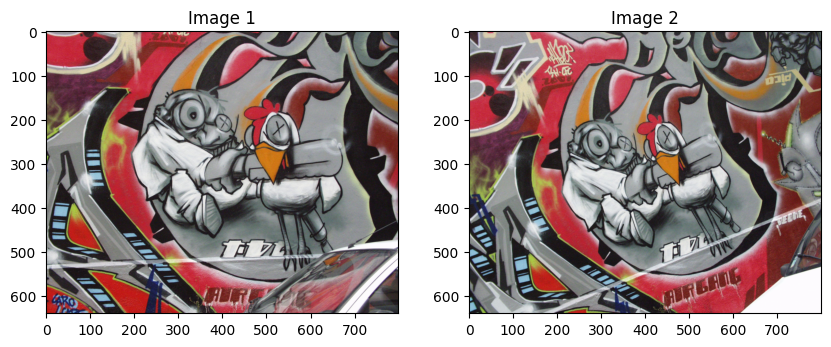

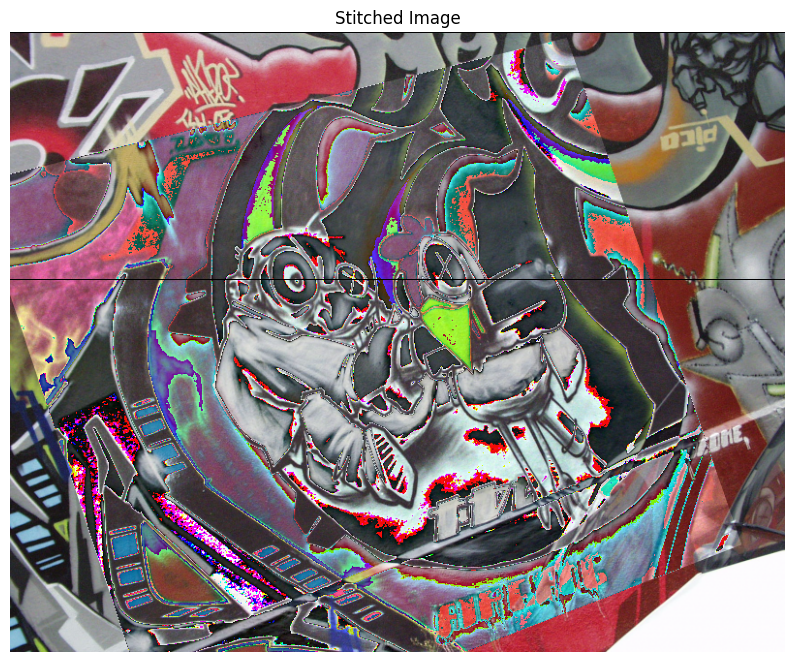

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the all 5 images
img1 = cv2.imread('img1.ppm', cv2.IMREAD_COLOR)
img2 = cv2.imread('img2.ppm', cv2.IMREAD_COLOR)

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and compute descriptors in the images
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# Initialize\a Brute Force Matcher and perform feature matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.56 * n.distance:
        good_matches.append(m)

# Extract matched keypoints coordinates in both images
source_points = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
destination_points = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# RANSAC to compute the homography matrix
def ransac_homography(src_pts, dst_pts, num_iteration=1000, inlier_threshold=5.0):
    best_homography = None
    most_inliers = 0

    for _ in range(num_iteration):
        # Randomly select 4 points pairs
        indices = np.random.choice(len(src_pts), 4, replace=False)
        src_sample = src_pts[indices]
        dst_sample = dst_pts[indices]

        # Compute the homography matrix using the 4 random points pairs
        homography_matrix, _ = cv2.findHomography(src_sample, dst_sample, cv2.RANSAC, inlier_threshold)

        # Wrap all source points using the computed homography matrix
        wraped_pts = cv2.perspectiveTransform(src_pts, homography_matrix)

        # Count inliers
        num_inliers = np.sum(np.linalg.norm(wraped_pts - dst_pts, axis=2) < inlier_threshold)

        # Update the best homography matrix if more inliers are found
        if num_inliers > most_inliers:
            most_inliers = num_inliers
            best_homography = homography_matrix

    return best_homography

# Compute the homography matrix using RANSAC
homography_matrix = ransac_homography(source_points, destination_points)

# Warp the images using the computed homography matrix
stitched_image = cv2.warpPerspective(img1, homography_matrix, (img2.shape[1], img2.shape[0]))

# Create a mask to combine the two images
mask = (stitched_image == 0).astype(np.uint8) * 255
stitched_image += img2
stitched_image[mask] = 0

# Plot image1 and image2 side-by-side
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.show()


# Display the stitched image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Stitched Image')
plt.show()
        


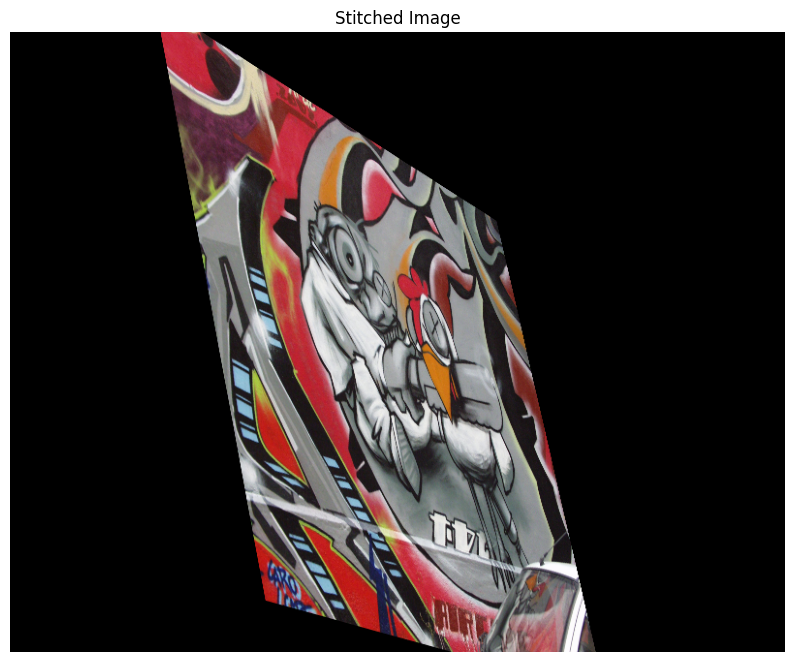

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to find SIFT matches between two images
def find_sift_match(img1, img2):
    sift = cv2.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)
    
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(descriptors_1, descriptors_2)
    sorted_matches = sorted(matches, key=lambda x: x.distance)
    
    return sorted_matches, [keypoints_1, keypoints_2]

# Function to compute SSD (Sum of Squared Differences) between correspondences and a homography
def SSD(corres, h):
    pts1 = np.transpose(np.matrix([corres[0].item(0), corres[0].item(1), 1]))
    estimate_p1 = np.dot(h, pts1)
    estimate_p2 = (1 / estimate_p1.item(2)) * estimate_p1
    pts2 = np.transpose(np.matrix([corres[0].item(2), corres[0].item(3), 1]))
    error = pts2 - estimate_p2
    return np.linalg.norm(error)

# Function to compute homography matrix from correspondences
def Homography(correspondences):
    Lst = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])
        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        Lst.append(a1)
        Lst.append(a2)
    
    matrixA = np.matrix(Lst)
    u, s, v = np.linalg.svd(matrixA)
    h = np.reshape(v[8], (3, 3))
    h = (1 / h.item(8)) * h
    return h

# Function to perform RANSAC to find the best homography
def ransac(corr, thresh):
    max_inliers = []
    final_h = None
    for _ in range(1000):
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        random_four = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        random_four = np.vstack((random_four, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        random_four = np.vstack((random_four, corr4))
        
        h = Homography(random_four)
        inliers = []
        for i in range(len(corr)):
            d = SSD(corr[i], h)
            if d < 5:
                inliers.append(corr[i])
        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            final_h = h
        if len(max_inliers) > (len(corr) * thresh):
            break
    return final_h, max_inliers

# Function to create a correspondence list from matches
def corr_list(matches1, key):
    correspondence_list1 = []
    keypoints1 = [key[0], key[1]]
    for match in matches1:
        (x1, y1) = keypoints1[0][match.queryIdx].pt
        (x2, y2) = keypoints1[1][match.trainIdx].pt
        correspondence_list1.append([x1, y1, x2, y2])
    return correspondence_list1

# Load your 5 images here
img1 = cv2.imread('img1.ppm', cv2.IMREAD_COLOR)
img2 = cv2.imread('img2.ppm', cv2.IMREAD_COLOR)
img3 = cv2.imread('img3.ppm', cv2.IMREAD_COLOR)
img4 = cv2.imread('img4.ppm', cv2.IMREAD_COLOR)
img5 = cv2.imread('img5.ppm', cv2.IMREAD_COLOR)

# Convert images to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)

# Find SIFT matches between images
matches1_2, keypoints_1_2 = find_sift_match(img1, img2)
matches2_3, keypoints_2_3 = find_sift_match(img2, img3)
matches3_4, keypoints_3_4 = find_sift_match(img3, img4)
matches4_5, keypoints_4_5 = find_sift_match(img4, img5)

# Create correspondence lists
corrList1_2 = corr_list(matches1_2, keypoints_1_2)
corrList2_3 = corr_list(matches2_3, keypoints_2_3)
corrList3_4 = corr_list(matches3_4, keypoints_3_4)
corrList4_5 = corr_list(matches4_5, keypoints_4_5)

# Convert correspondence lists to matrices
corrs1_2 = np.matrix(corrList1_2)
corrs2_3 = np.matrix(corrList2_3)
corrs3_4 = np.matrix(corrList3_4)
corrs4_5 = np.matrix(corrList4_5)

# Perform RANSAC to compute homographies
finalH1_2, inliers1_2 = ransac(corrs1_2, 0.6)
finalH2_3, inliers2_3 = ransac(corrs2_3, 0.6)
finalH3_4, inliers3_4 = ransac(corrs3_4, 0.6)
finalH4_5, inliers4_5 = ransac(corrs4_5, 0.6)

# Compute the final homography from img1 to img5
H = finalH1_2 @ finalH2_3 @ finalH3_4 @ finalH4_5

# Warp img1 onto img5 using the final homography
dst1 = cv2.warpPerspective(img1, H, (img5.shape[1], img5.shape[0]))

# Display the stitched image
plt.figure(figsize=(10, 10))
plt.imshow(dst1)
plt.axis('off')
plt.title('Stitched Image')
plt.show()
